In [38]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import datetime
import sklearn
import pickle


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [39]:
import pathlib
data_dir = pathlib.Path("car_data/Data")

In [40]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

182


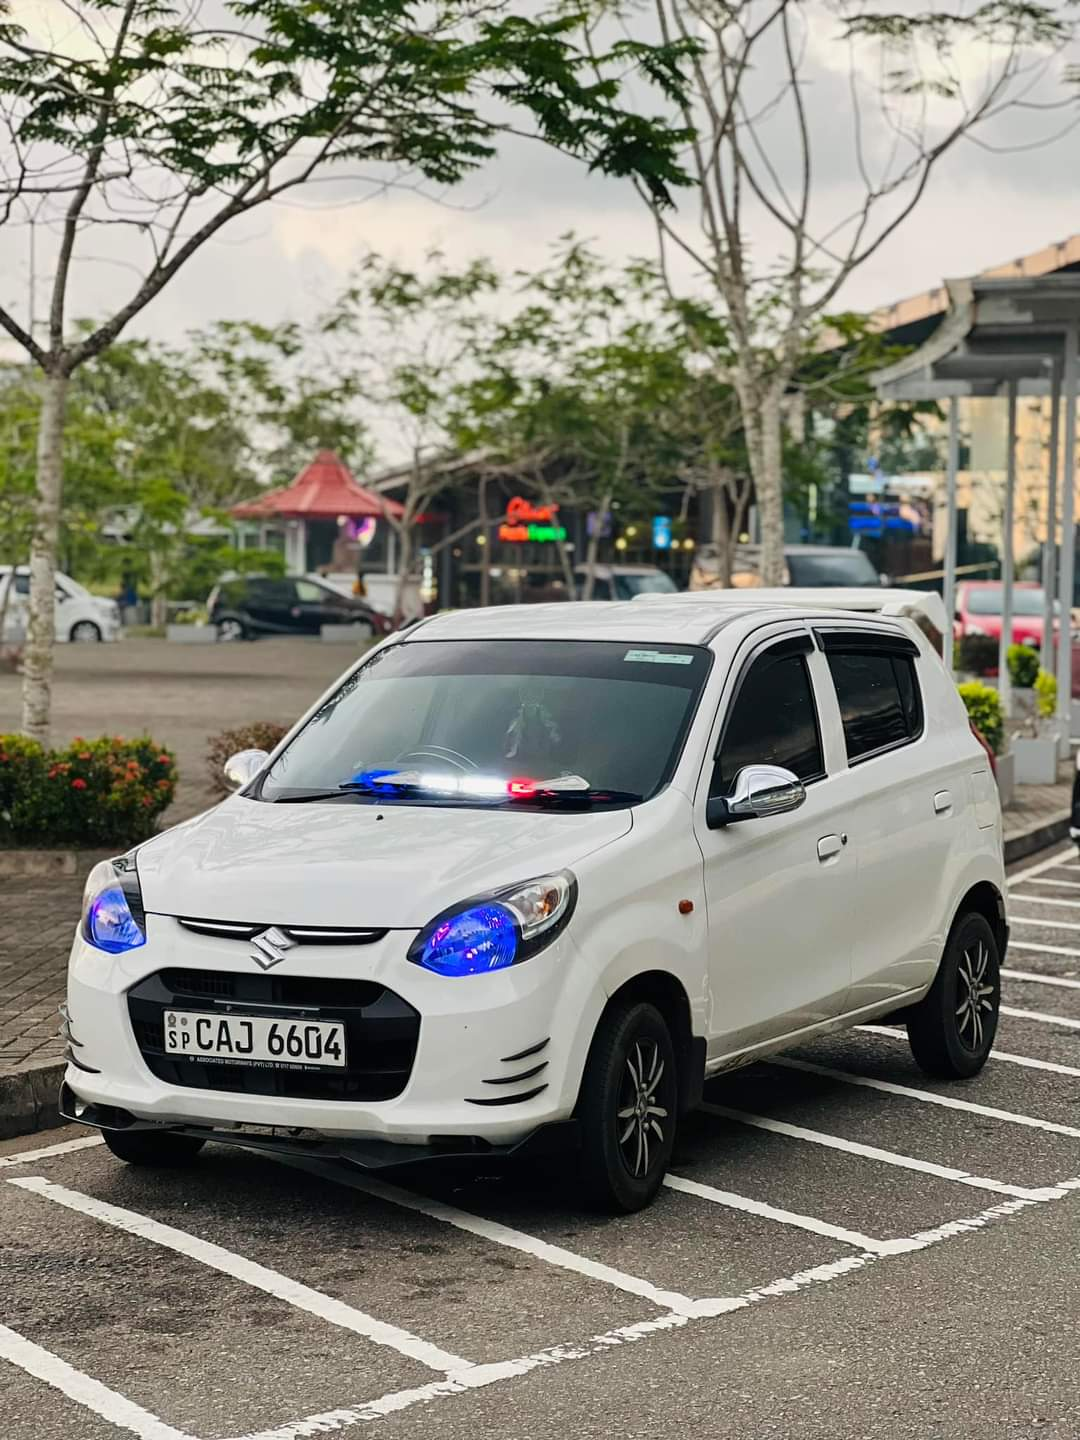

In [41]:
alto = list(data_dir.glob('alto/*'))
PIL.Image.open(str(alto[0]))

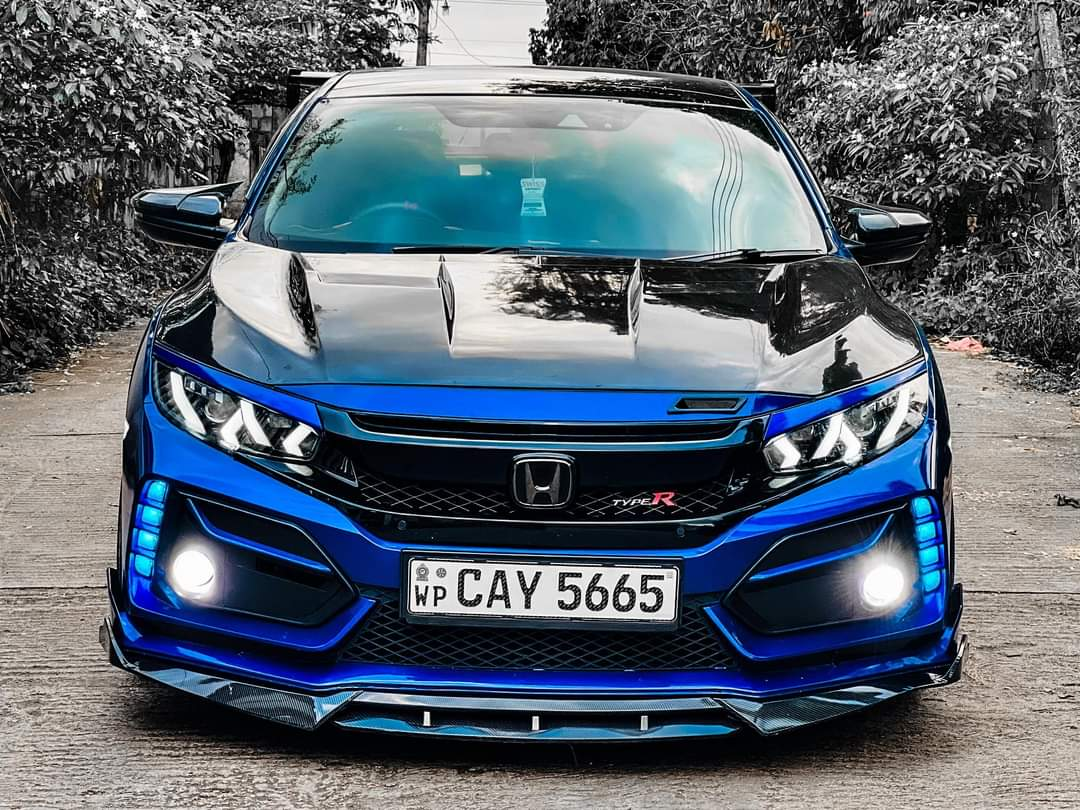

In [42]:
civic = list(data_dir.glob('civic/*'))
PIL.Image.open(str(civic[0]))

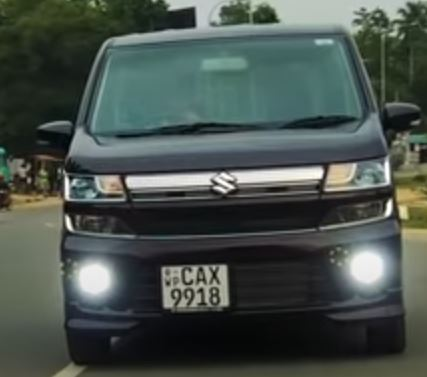

In [43]:

Wagonr = list(data_dir.glob('Suzuki Wagon R/*'))
PIL.Image.open(str(Wagonr[0]))

In [44]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
     image_size=(256,256),
  subset="training",
  seed=123)

Found 201 files belonging to 3 classes.
Using 161 files for training.


In [45]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
    image_size=(256,256),
  subset="validation",
  seed=123)

Found 201 files belonging to 3 classes.
Using 40 files for validation.


In [46]:
class_names = train_ds.class_names
print(class_names)

['Suzuki Wagon R', 'alto', 'civic']


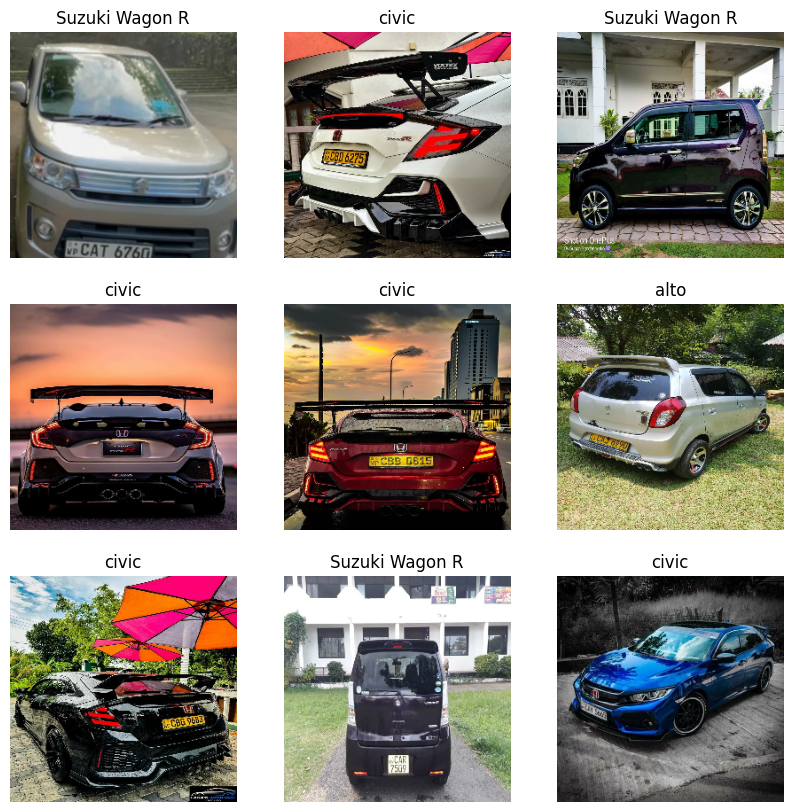

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [48]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


In [49]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [50]:
normalization_layer = layers.Rescaling(1./255)

In [51]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [52]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(256, 256, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [53]:
# from keras import backend as K

# def recall_m(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     recall = true_positives / (possible_positives + K.epsilon())
#     return recall

# def precision_m(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     precision = true_positives / (predicted_positives + K.epsilon())
#     return precision

# def f1_m(y_true, y_pred):
#     precision = precision_m(y_true, y_pred)
#     recall = recall_m(y_true, y_pred)
#     return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [56]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [57]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 64)       

In [58]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
6/6 [==============================] - 18s 3s/step - loss: 1.8602 - accuracy: 0.4037 - val_loss: 0.9639 - val_accuracy: 0.6250
Epoch 2/10
6/6 [==============================] - 6s 919ms/step - loss: 1.0225 - accuracy: 0.5280 - val_loss: 1.0006 - val_accuracy: 0.5250
Epoch 3/10
6/6 [==============================] - 4s 725ms/step - loss: 0.8265 - accuracy: 0.6211 - val_loss: 0.8700 - val_accuracy: 0.6750
Epoch 4/10
6/6 [==============================] - 4s 851ms/step - loss: 0.7571 - accuracy: 0.6335 - val_loss: 1.0635 - val_accuracy: 0.5500
Epoch 5/10
6/6 [==============================] - 4s 702ms/step - loss: 0.6706 - accuracy: 0.6770 - val_loss: 0.7659 - val_accuracy: 0.6750
Epoch 6/10
6/6 [==============================] - 4s 714ms/step - loss: 0.5107 - accuracy: 0.7826 - val_loss: 0.7691 - val_accuracy: 0.6000
Epoch 7/10
6/6 [==============================] - 4s 709ms/step - loss: 0.4061 - accuracy: 0.8261 - val_loss: 0.7735 - val_accuracy: 0.6000
Epoch 8/10
6/6 [======

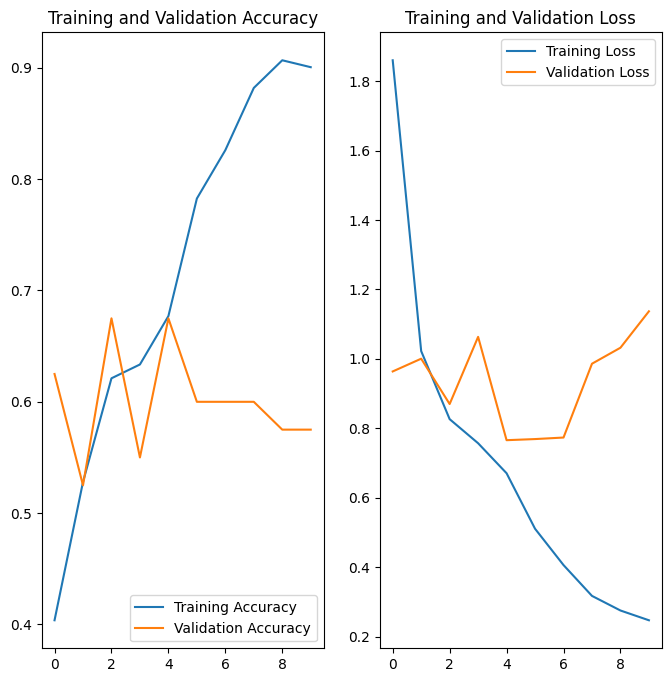

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [60]:
fil = "test2.jpeg"

img = tf.keras.utils.load_img(
    fil, target_size=(256, 256)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to Suzuki Wagon R with a 72.52 percent confidence.


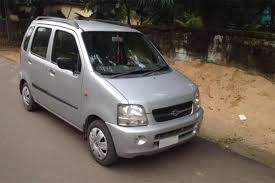

In [61]:
PIL.Image.open("test2.jpeg")

In [62]:
model.save("car_model.h5")

In [63]:
model = keras.models.load_model("car_model.h5")

In [65]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array


model = tf.keras.models.load_model('car_model.h5')

image_path = 'test1.jpeg'
image = load_img(image_path, target_size=(256, 256))
image_array = img_to_array(image)
input_data = image_array.reshape(1, 256, 256, 3) 

predictions = model.predict(input_data)
print(predictions)
score = tf.nn.softmax(predictions[0])
print(score)

[[ 4.34559    3.8452723 -4.746419 ]]
tf.Tensor([6.2249041e-01 3.7743953e-01 7.0068607e-05], shape=(3,), dtype=float32)


In [66]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to Suzuki Wagon R with a 62.25 percent confidence.


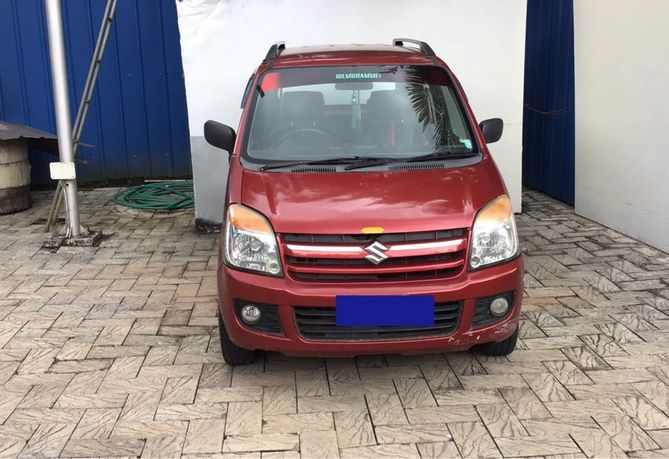

In [67]:
PIL.Image.open("test1.jpeg")